Modified from the UNet2D starter code provided by Diffusers on [Colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb).

In [ ]:
NOISY = True  # Set to True to train on noisy data, False to train on noise-free data

## Training configuration

In [1]:
from dataclasses import dataclass
import os

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 2
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 1
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "mitodiff_noisefree_final" if not NOISY else "mitodiff_noisy_final"  # the model name locally and on the HF Hub

    # Data Config
    mito_data_dir = "../data_experiments/data/mito_variable_sbrs_big_80nm/xy_split_noisefree_uint8/" if not NOISY else "../data_experiments/data/mito_variable_sbrs_big_80nm/xy_split_uint8/"
    train_test_split = 0.8  # the fraction of the dataset to use for training
    take_subset = 1.0  # take a subset of the dataset for training and evaluation
    val_every_n_steps = 1000

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = False  # overwrite the old model when re-running the notebook
    seed = 1234  # random seed for reproducibility


config = TrainingConfig()
if os.path.exists(config.output_dir):
    raise ValueError(f"Output directory {config.output_dir} already exists. Please specify a new directory.")

## Load the dataset

In [2]:
import datasets
from datasets import load_dataset
import glob
import os
import numpy as np

# Load the dataset
IMAGES = glob.glob(os.path.join(config.mito_data_dir, "*.tif"))
IMAGES = sorted(IMAGES)
IMAGES = IMAGES[:int(len(IMAGES) * config.take_subset)]  # take a subset of the dataset
dataset = datasets.Dataset.from_dict(
    {"image": IMAGES},
    features=datasets.Features({"image": datasets.Image()})
)

dataset = dataset.train_test_split(test_size=(1 - config.train_test_split), seed=config.seed)
train_dataset = dataset["train"]
val_dataset = dataset["test"]

print(train_dataset)
print(val_dataset)

Dataset({
    features: ['image'],
    num_rows: 80000
})
Dataset({
    features: ['image'],
    num_rows: 20000
})


/tmp/ipykernel_515814/1713788894.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


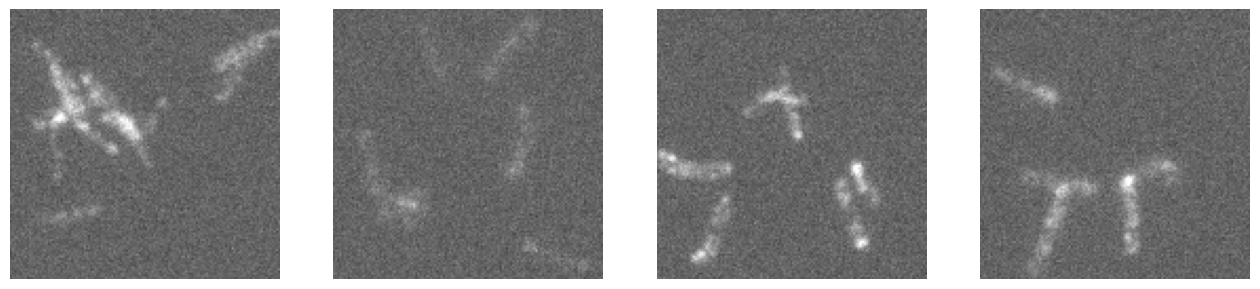

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(train_dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

The images are all different sizes though, so you'll need to preprocess them first:

* `Resize` changes the image size to the one defined in `config.image_size`.
* `RandomHorizontalFlip` augments the dataset by randomly mirroring the images.
* `Normalize` is important to rescale the pixel values into a [-1, 1] range, which is what the model expects.

In [4]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        # transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x/255.0),  # scale to [0., 1.] range
        transforms.Normalize([0.5], [0.5]),
    ]
)

val_preprocess = transforms.Compose(
    [
        # transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x/255.0),  # scale to [0., 1.] range
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [5]:
def transform(examples):
    images = [preprocess(image) for image in examples["image"]]
    return {"images": images}

def val_transform(examples):
    images = [val_preprocess(image) for image in examples["image"]]
    return {"images": images}


train_dataset.set_transform(transform)
val_dataset.set_transform(val_transform)

In [6]:
import torch

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=config.eval_batch_size, shuffle=False)

## Create a UNet2DModel

In [7]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [8]:
sample_image = train_dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 1, 128, 128])


In [9]:
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 1, 128, 128])


## Create a scheduler

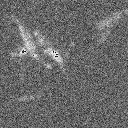

In [10]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0].squeeze(), mode="L")

The training objective of the model is to predict the noise added to the image. The loss at this step can be calculated by:

In [11]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

## Train the model

In [12]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [13]:
from diffusers import DDPMPipeline
import math
import os


def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, step, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=1, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{step:05d}.png")

In [14]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import wandb
import os


def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, val_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="wandb",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, val_dataloader, lr_scheduler
    )

    global_step = 0
    best_val_loss = math.inf

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)

            # Validation
            if global_step % config.val_every_n_steps == 0 and accelerator.is_main_process:
                # Validation loss
                model.eval()
                with torch.no_grad():
                    val_loss = 0.0
                    for val_batch in tqdm(val_dataloader, desc="Validation", leave=False):
                        clean_images = val_batch["images"]
                        noise = torch.randn(clean_images.shape).to(clean_images.device)
                        bs = clean_images.shape[0]
                        timesteps = torch.randint(
                            0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
                        ).long()
                        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
                        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                        val_loss += F.mse_loss(noise_pred, noise).item()
                    val_loss /= len(val_dataloader)
                    logs["val_loss"] = val_loss
                    progress_bar.set_postfix(**logs)
                model.train()
                if val_loss < best_val_loss:
                    best_val_loss = val_loss

                # Save sample images and log to wandb
                pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
                evaluate(config, global_step, pipeline)
                for tracker in accelerator.trackers:
                    if tracker.name == "wandb":
                        formatted_images = []
                        img_path = os.path.join(config.output_dir, f"samples/{global_step:05d}.png")
                        formatted_images.append(wandb.Image(Image.open(img_path), caption=f"Step: {global_step}"))
                        tracker.log({"validation": formatted_images})

                # Save model if best so far
                if val_loss == best_val_loss and config.output_dir is not None:
                    pipeline.save_pretrained(config.output_dir)
                    with open(f"{config.output_dir}/best_val_loss.txt", "w") as f:
                        f.write(f'Model saved at step {global_step}. Val Loss: {best_val_loss:.6f}. Train Loss: {loss.item():.6f}')

            accelerator.log(logs, step=global_step)
            global_step += 1

In [15]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, val_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Launching training on one GPU.


wandb: Currently logged in as: iamsuyogjadhav (personal-suyog). Use `wandb login --relogin` to force relogin


  0%|          | 0/5000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 0 is less than current step: 1. Dropping entry: {'loss': 1.1602144241333008, 'lr': 2.0000000000000002e-07, 'step': 0, 'val_loss': 1.1639122812271119, '_timestamp': 1726421770.5144196}).


Validation:   0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Validation:   0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Once training is complete, take a look at the final 🦋 images 🦋 generated by your diffusion model!

# Inference


In [16]:
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Load model
model = UNet2DModel.from_pretrained("mitodiff/unet").to("cuda")

# Initialize noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
# generator=torch.manual_seed(1234)

  0%|          | 0/1000 [00:00<?, ?it/s]

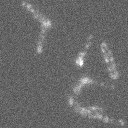

In [5]:
pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipe(batch_size=16).images[0]